# Point Cloud Diffusion 

## Imports

In [ ]:
# pclab
from pclab.datasets.modelnet import ModelNet40
from pclab.transforms import *
from pclab.learner import *
from pclab.utils import quick_vis, DataLoaders, to_device
from pclab.models.pointnet import LinearLayer, TNET, feature_transform_regularizer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

# Other
from random import random
from functools import partial
import fastcore.all as fc

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Setting the latent dimension for the whole pipeline:

In [ ]:
latent_dim = 32

## Dataset

In [ ]:
path = "/home/ioannis/Desktop/programming/data"
path = "/home/vvr/Desktop/vlassisgiannis/new_exps/data"

transforms = [RandomPointKeep(1024), UnitSphereNormalization(), AnisotropicScale(), ToTensor()]

train_dataset = ModelNet40(path, 2048, 'train', transforms=transforms, category=0)
valid_dataset = ModelNet40(path, 2048, 'test' , transforms=transforms, category=0)


train_dl, valid_dl = map(partial(DataLoader, batch_size=32, shuffle=True, num_workers=8, drop_last=True), (train_dataset, valid_dataset))

dls = DataLoaders(train_dl, valid_dl)

## Point AutoEncoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = LinearLayer(in_features, out_features)
        self.ln2 = LinearLayer(out_features, out_features, use_norm=True, use_relu=False)
        
    def forward(self, pc): # expecting `pc` to be of shape `BxFxN`, where `F` is the number of input features and `N` is the number of points in the point cloud
        return self.ln2(self.ln1(pc))

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = LinearLayer(in_features, in_features)
        self.ln2 = LinearLayer(in_features, out_features, use_norm=False, use_relu=False)

    def forward(self, pc): # expecting `pc` to be of shape `BxFxN`, where `F` is the number of input features and `N` is the number of points in the point cloud
        return self.ln2(self.ln1(pc))

Create a model that will contain both the encoder and the decoder subnetworks

In [ ]:
class PointAutoEncoder(nn.Module):
    
    def __init__(self, point_dim, latent_dim):
        super().__init__()
        self.point_dim, self.latent_dim = point_dim, latent_dim
        
        self.encoder = Encoder(point_dim, latent_dim)
        self.decoder = Decoder(latent_dim, point_dim)
        
        self.loss_fn = nn.MSELoss()
    
    def encode(self, pc):
        return self.encoder(pc)
    
    def decode(self, latent_pc):
        return self.decoder(latent_pc)
    
    def forward(self, pc):
        # encoding points to latent space
        latent_repr = self.encode(pc)
        
        # decoding points back to point space
        pc_rec = self.decode(latent_repr)
        
        return pc_rec

### Training Callback
- Add noise to the input batch
- Compute the correct loss

In [ ]:
class PointAutoEncoderCB(TrainCB):
    order = 0
    def __init__(self, noise_scale=0.2):
        super().__init__()
        self.noise_scale=noise_scale
        
    def before_batch(self, learn):
        pc, label = learn.batch
        
        B = pc.shape[0]     
        
        # create noise 
        noise = self.noise_scale * torch.rand_like(pc).to(pc.device)
        pc = pc + noise 
        
        learn.batch = pc.permute(0, 2, 1)
    
    def predict(self, learn): learn.preds = learn.model(learn.batch)
    
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, learn.batch)

# Train the model

## LRFinder

In [ ]:
autoencoder = PointAutoEncoder(point_dim=3, latent_dim=64)

In [ ]:
cbs = [DeviceCB(),PointAutoEncoderCB()]
opt_func = partial(optim.Adam, eps=1e-5)
learn = Learner(autoencoder, dls, nn.MSELoss(), cbs=cbs, lr=1e-4, opt_func=opt_func)

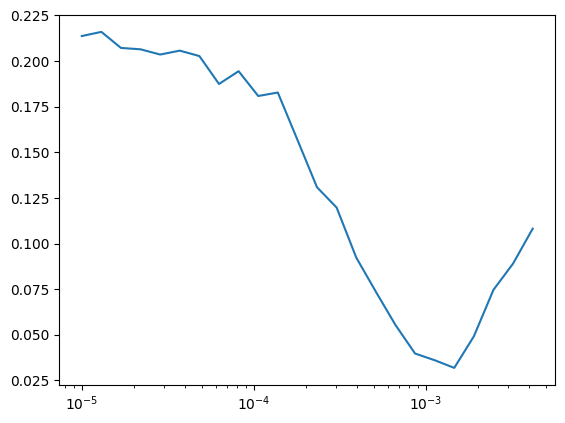

In [ ]:
learn.lr_find(max_mult=3)

## Training

Setting up the scheduler

In [ ]:
lr = 0.1 #0.05
epochs = 10
total_steps = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

Setting the callbacks

In [ ]:
cbs = [PointAutoEncoderCB(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [ ]:
autoencoder = PointAutoEncoder(point_dim=3, latent_dim=latent_dim)
learn = Learner(autoencoder, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

0.118,0,train
0.118,0,train
0.025,0,eval
0.009,1,train
0.023,1,eval
0.003,2,train
0.009,2,eval
0.004,3,train
0.002,3,eval
0.002,4,train
0.002,4,eval


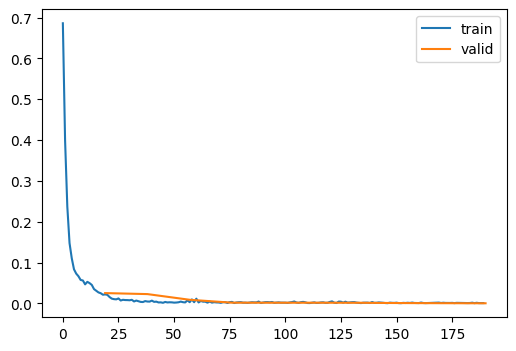

In [ ]:
learn.fit(epochs)

# Test the Point AutoEncoder

In [ ]:
pc = next(iter(dls.valid))[0][0].unsqueeze(0).permute(0, 2, 1).cuda()
pc.shape

torch.Size([1, 3, 1024])

In [ ]:
latent = autoencoder.encode(pc)

In [ ]:
latent.shape

torch.Size([1, 32, 1024])

In [ ]:
latent.mean(), latent.std()

(tensor(-0.1189, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9187, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
pc_rec = autoencoder.decode(latent)
pc_rec.max(), pc_rec.min()

(tensor(1.0065, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-1.0279, device='cuda:0', grad_fn=<MinBackward1>))

In [ ]:
quick_vis(pc)

In [ ]:
quick_vis(pc_rec)

# DDPM

## Create a network that will hundle the denoising
This is usually a UNET but in this case it will be a PointNet-like network.

In [ ]:
class Denoiser(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        
        self.TNETin = TNET(feature_dim)
        self.ln1 = LinearLayer(feature_dim, feature_dim)
        self.TNEThid = TNET(feature_dim)
        self.ln2 = LinearLayer(feature_dim, feature_dim * 2)
        
        self.ln_out1 = LinearLayer(feature_dim * 4, feature_dim)
        self.ln_out2 = LinearLayer(feature_dim, feature_dim, use_norm=False, use_relu=False)
        
    def forward(self, latent):
        
        self.m1 = self.TNETin(latent)
        latent = self.m1 @ latent
        
        latent = self.ln1(latent)
        self.m2 = self.TNEThid(latent)
        latent = self.m2 @ latent
        latent = self.ln2(latent)
        
        B, F, N = latent.shape
        latent_glob = latent.max(dim=-1, keepdim=True)[0]
        latent_glob = latent_glob.repeat(1, 1, N)
        
        latent = torch.cat([latent, latent_glob], dim=1)
        
        latent = self.ln_out1(latent)
        latent = self.ln_out2(latent)
        
        return latent
    
    @property
    def regularization_loss(self):
        return feature_transform_regularizer(self.m1) + feature_transform_regularizer(self.m2)

In [ ]:
sample = next(iter(dls.valid))[0].permute(0, 2, 1).cuda()
sample.shape

torch.Size([32, 3, 1024])

In [ ]:
#model.eval()
latent = autoencoder.encode(sample)
latent.shape

torch.Size([32, 32, 1024])

In [ ]:
unet = Denoiser(latent_dim).cuda()

In [ ]:
latent_d = unet(latent)
latent_d.shape

torch.Size([32, 32, 1024])

## Adding noise:

### Calculating the noise to go to the *next* timestep:
$x_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon, \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

### Calculating the noise to go at a *specific* timestep:
$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

In [ ]:
def noisify(x0,        # the original data
            ᾱ,         # values across all timesteps
            n_steps):  # total number of steps 
    device = x0.device
    n = len(x0)
    # selecting a random timestep
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    # generating noise from a normal distribution
    ε = torch.randn(x0.shape, device=device)
    # selecting the value to of ᾱ based on the random step
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1).to(device)
    # adding the noise to the sample
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    #return (xt, t.to(device)), ε
    return xt, ε

### Test the process of adding noise.

In [ ]:
# Creating the noise stats for a forward diffusion process
beta_min = 0.0001
beta_max = 0.002
n_steps = 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
α = 1. - beta
ᾱ = torch.cumprod(α, dim=0)

In [ ]:
# adding noise to the latent
noisy_latent = noisify(latent, ᾱ, n_steps)
noisy_latent[0].shape

torch.Size([32, 32, 1024])

In [ ]:
# use the decoder to reconstrust the point cloud
rec_noisy_sample = autoencoder.decode(noisy_latent[0])
quick_vis(rec_noisy_sample.permute(0, 2, 1)[0])

## Backward process

Given a noise prediction we want to go for the step **t+1** to step **t**.

The idea is that we predict the noise that would go directly from the timestep **t-1** to the timestep **0**. Then we try to predict the timestep **t-1** and add noise to go to step **t**.

## DDPM callback

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds        

In [ ]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
        
    def before_batch(self, learn): 
        # use the encoder to get the latent space vector
        with torch.no_grad():
            latent = autoencoder.encode(learn.batch[0].permute(0, 2, 1))
        # add noise to the encoded latent
        learn.batch = noisify(latent, self.ᾱ, self.n_steps)
    
    def after_loss(self, learn):
        learn.loss = learn.loss + 0.001 * learn.model.regularization_loss
    
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [ ]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

In [ ]:
unet = Denoiser(latent_dim)

autoencoder.eval()

lr = 0.001
epochs = 400
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

opt_func = partial(optim.Adam, eps=1e-5)

learn = TrainLearner(unet, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

1.190,0,train
1.190,0,train
1.127,0,eval
1.097,1,train
1.104,1,eval
1.063,2,train
1.030,2,eval
1.034,3,train
0.982,3,eval
1.013,4,train
1.002,4,eval


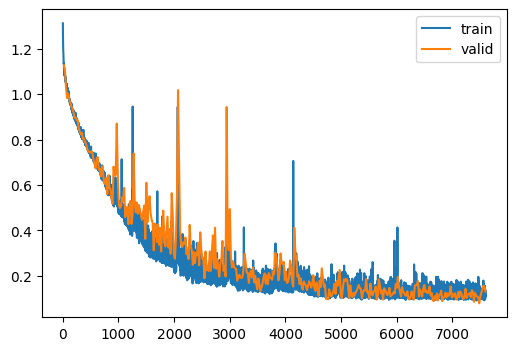

In [ ]:
learn.fit(epochs)

In [ ]:
samples = ddpm_cb.sample(learn.model, (1, latent_dim, 1024))

In [ ]:
generated_latent = samples[-1]
generated_latent.shape

torch.Size([1, 32, 1024])

In [ ]:
generated_pc = autoencoder.decode(generated_latent.cuda())
quick_vis(generated_pc)

In [ ]:
generated_pc.min(), generated_pc.max()

(tensor(-0.5205, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5199, device='cuda:0', grad_fn=<MaxBackward1>))